# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test: Solving and simulating the household problem](#toc2_)    
- 3. [Find stationary equilibrium](#toc3_)    
- 4. [Expected discounted utility](#toc4_)       
- 5. [Find transition path](#toc5_)
- 6. [Policy functions](#toc6_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [19]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [20]:
model = HANCWelfareModelClass(name='baseline')

In [21]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [22]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.chi = 0.0
ss.S = 0.0
ss.tau = 0.015

We can now solve and simulate:

In [23]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.5 secs [345 iterations]


In [24]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 0.0 secs [399 iterations]


And we can check whether the results make sort of sense:

In [25]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.02
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


## 3. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [26]:
ss.G = 0.0
ss.chi = 0.0

In [27]:
model.find_ss(do_print=True)

starting at KL=3.8624
starting at LY=1.0590



    fjac: array([[-0.99992782,  0.01201481],
       [-0.01201481, -0.99992782]])
     fun: array([ 2.79682943e-11, -4.00901534e-13])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.29430611e-08,  6.09553066e-10])
       r: array([-8.15871488, -4.18719862, -1.0429701 ])
  status: 1
 success: True
       x: array([3.67339044, 0.92250446])

steady state found in 7.5 secs
ss.K =  3.389
ss.A_hh =  3.389
ss.Y =  1.363
ss.r =  0.021
ss.w =  1.034
ss.G =  0.000
ss.LG =  0.000
ss.LY =  0.923
ss.tau =  0.000
ss.clearing_A = 2.80e-11
ss.clearing_L = -4.01e-13
ss.clearing_Y = 0.00e+00


In [28]:
model.test_path()

shocks: chi G 
unknowns: K LY 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 tau              0.0e+00
 wt               0.0e+00
 LG               0.0e+00
 L                0.0e+00
 S                0.0e+00
 B                0.0e+00
hh
 A_hh             2.7e-09
 C_hh             1.3e-10
 ELL_hh           1.2e-10
 L_hh             1.0e-10
 INC_hh           4.9e-11
 U_hh             7.0e-07
blocks.market_clearing
 I                    nan
 clearing_A       2.7e-09 [target]
 clearing_L       1.0e-10 [target]
 clearing_Y       1.3e-10


In [29]:
model.info(only_blocks=True,ss=True)

production_firm: [K=3.39,LY=0.92] -> [rK=0.12,w=1.03,Y=1.36]
mutual_fund: [K=3.39,rK=0.12] -> [A=3.39,r=0.02]
government: [w=1.03,G=0.00,LY=0.92,chi=0.00] -> [tau=0.00,wt=1.03,LG=0.00,L=0.92,S=0.00,B=0.00]
hh: [S=0.00,chi=0.00,r=0.02,tau=0.00,wt=1.03] -> [A_hh=3.39,C_hh=1.02,ELL_hh=0.99,L_hh=0.92,INC_hh=1.02,U_hh=-100000001.62]
market_clearing: [A=3.39,A_hh=3.39,LY=0.92,LG=0.00,L_hh=0.92,L=0.92,Y=1.36,C_hh=1.02,K=3.39,G=0.00] -> [I=0.34,clearing_A=0.00,clearing_L=-0.00,clearing_Y=0.00]


## 4. <a id='toc9_'></a>[Expected discounted utility](#toc0_)

In [30]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
print(f'Expected discounted utility with ss.G, ss.LG, ss.chi = 0: {V_hh_ss}')

Expected discounted utility with ss.G, ss.LG, ss.chi = 0: -2500000037.032259


In [15]:
def optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values):
    results = {}

    for Gamma_Y in Gamma_Y_values:
        par.Gamma_Y = Gamma_Y

        # Part b) and c)
        for chi in chi_values:
            ss.chi = chi

            def target(G):
                # Use the relationship G = Gamma_G * LG
                LG = G/par.Gamma_G
                ss.G = G
                ss.LG = LG
                model.find_ss(do_print=False)
                return -ss.U_hh

            # Optimize G and LG given 
            res = optimize.minimize_scalar(target, bounds=(0.0, 0.5), method='bounded')
            optimal_G = res.x
            optimal_LG = optimal_G/par.Gamma_G

            # Update model with the optimal values
            ss.G = optimal_G
            ss.LG = optimal_LG
            model.find_ss(do_print=False)
            
            # Compute additional results
            V_hh_ss = np.sum([par.beta**t * ss.U_hh for t in range(par.T)])
            G_over_Y = ss.G / ss.Y

            results[(chi, Gamma_Y)] = {
                'opt_G': optimal_G,
                'opt_LG': optimal_LG,
                'V_hh_ss': V_hh_ss,
                'G_over_Y': G_over_Y,
            }

            print(f"For chi = {chi}, Gamma_Y = {Gamma_Y}:")
            print(f"Optimal ss.G: {optimal_G:.4f}")
            print(f"Optimal ss.LG: {optimal_LG:.4f}")
            print(f"Total expected utility: {V_hh_ss:.4f}")
            print(f"G/Y: {G_over_Y:.4f}\n")

    return results

In [16]:
result_fixed_chi = optimize_welfare_policies(model,par,ss,chi_values=[0.0],Gamma_Y_values=[1.0])

For chi = 0.0, Gamma_Y = 1.0:
Optimal ss.G: 0.3199
Optimal ss.LG: 0.3199
Total expected utility: -153.9826
G/Y: 0.3769



In [17]:
chi_values = [-0.01, 0.01] 
results = optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values=[1.0])

/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:60: RuntimeWarning: invalid value encountered in double_scalars
  ss.rK = par.alpha*par.Gamma_Y*(KL)**(par.alpha-1)
/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:61: RuntimeWarning: invalid value encountered in double_scalars
  ss.w = (1.0-par.alpha)*par.Gamma_Y*(KL)**par.alpha


AssertionError: invalid value r = nan

In [ ]:
chi_values = [-0.01, 0.0, 0.01]
result_increased_TFP = optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y_values=[1.1])

For chi = -0.001:
Optimal ss.LG: 0.2815
Optimal ss.G: 0.2815
Total expected utility: -162.0525
G/Y: 0.2944

For chi = 0.0:
Optimal ss.LG: 0.2810
Optimal ss.G: 0.2810
Total expected utility: -162.2559
G/Y: 0.2943

For chi = 0.001:
Optimal ss.LG: 0.2806
Optimal ss.G: 0.2806
Total expected utility: -162.4615
G/Y: 0.2943



In [ ]:
def optimize_welfare_policies(model, par, ss, chi_values, Gamma_Y):

    def target(G, chi):
        ss.chi = chi
        par.Gamma_Y = Gamma_Y
        ss.G = G
        model.find_ss(do_print=False)
        return -ss.U_hh

    results = {}

    for chi in chi_values:
        res = optimize.minimize_scalar(target, args=(chi,), bounds=(0.0, 0.1), method='bounded')
        ss.G = res.x
        max_U_hh = res.fun

        model.find_ss(do_print=True)
        V_hh_ss = np.sum([par.beta**t * ss.U_hh for t in range(par.T)])

        results[chi] = {
            'opt_G': ss.G,
            'opt_LG': ss.LG,
            'V_hh_ss': V_hh_ss,
            'G_over_Y': ss.G / ss.Y
        }

        print(f"For chi = {chi}:")
        print(f"Optimal ss.G: {results[chi]['opt_G']:.4f}")
        print(f"Optimal ss.LG: {results[chi]['opt_LG']:.4f}")
        print(f"Total expected utility: {results[chi]['V_hh_ss']:.4f}")
        print(f"G/Y: {results[chi]['G_over_Y']:.4f}\n")

    return results

## 5. <a id='toc9_'></a>[Find transition path](#toc0_)

In [18]:
# ss.LG = 0.2810
model.compute_jacs()
model.find_transition_path(shocks=['G','chi'],do_print=True)

Traceback (most recent call last):
  File "/home/b163467@PROD.SITAD.DK/.conda/envs/enrich/lib/python3.9/site-packages/GEModelTools/GEModelClass.py", line 1033, in _calc_jac_hh_fakenews
    self.call_hh_function('solve_hh_backwards',one_step_ss)
  File "/home/b163467@PROD.SITAD.DK/.conda/envs/enrich/lib/python3.9/site-packages/GEModelTools/GEModelClass.py", line 464, in call_hh_function
    func.py_func(**inputs)
  File "/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/household_problem.py", line 28, in solve_hh_backwards
    interp_1d_vec(m_endo,c_endo,m_exo,c[i_fix,i_z,:])
ZeroDivisionError: division by zero


ZeroDivisionError: division by zero

### shocks ###


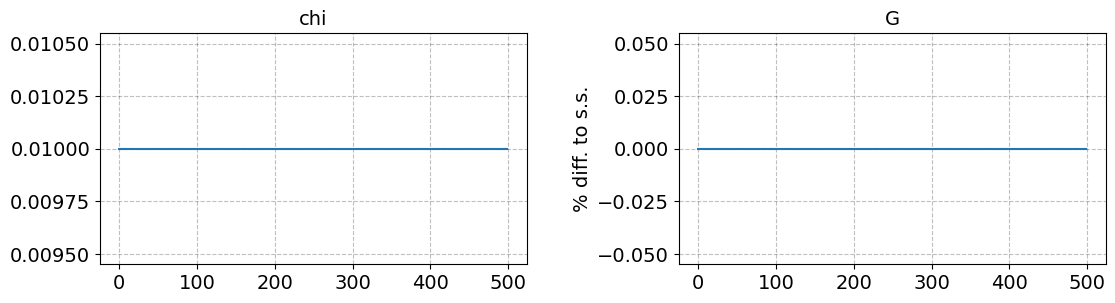


### varnames ###


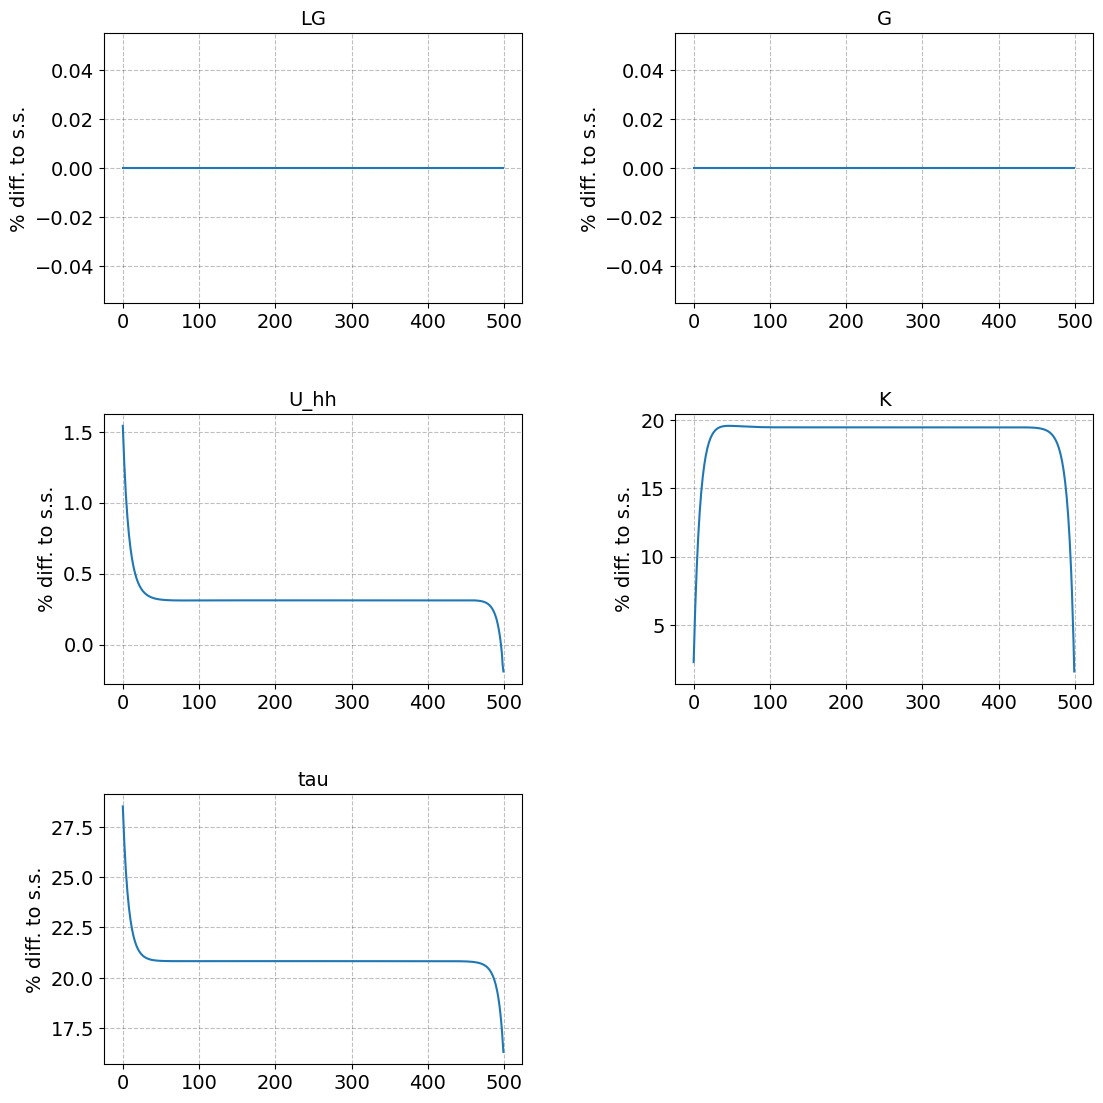


### tagets ###


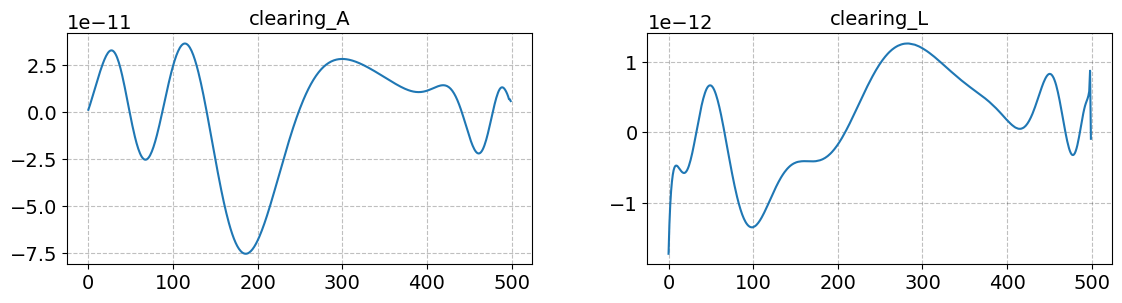

In [13]:
model.show_IRFs(varnames=['LG','G','U_hh','K','tau'],lvl_value=['U_hh'],ncols=2)

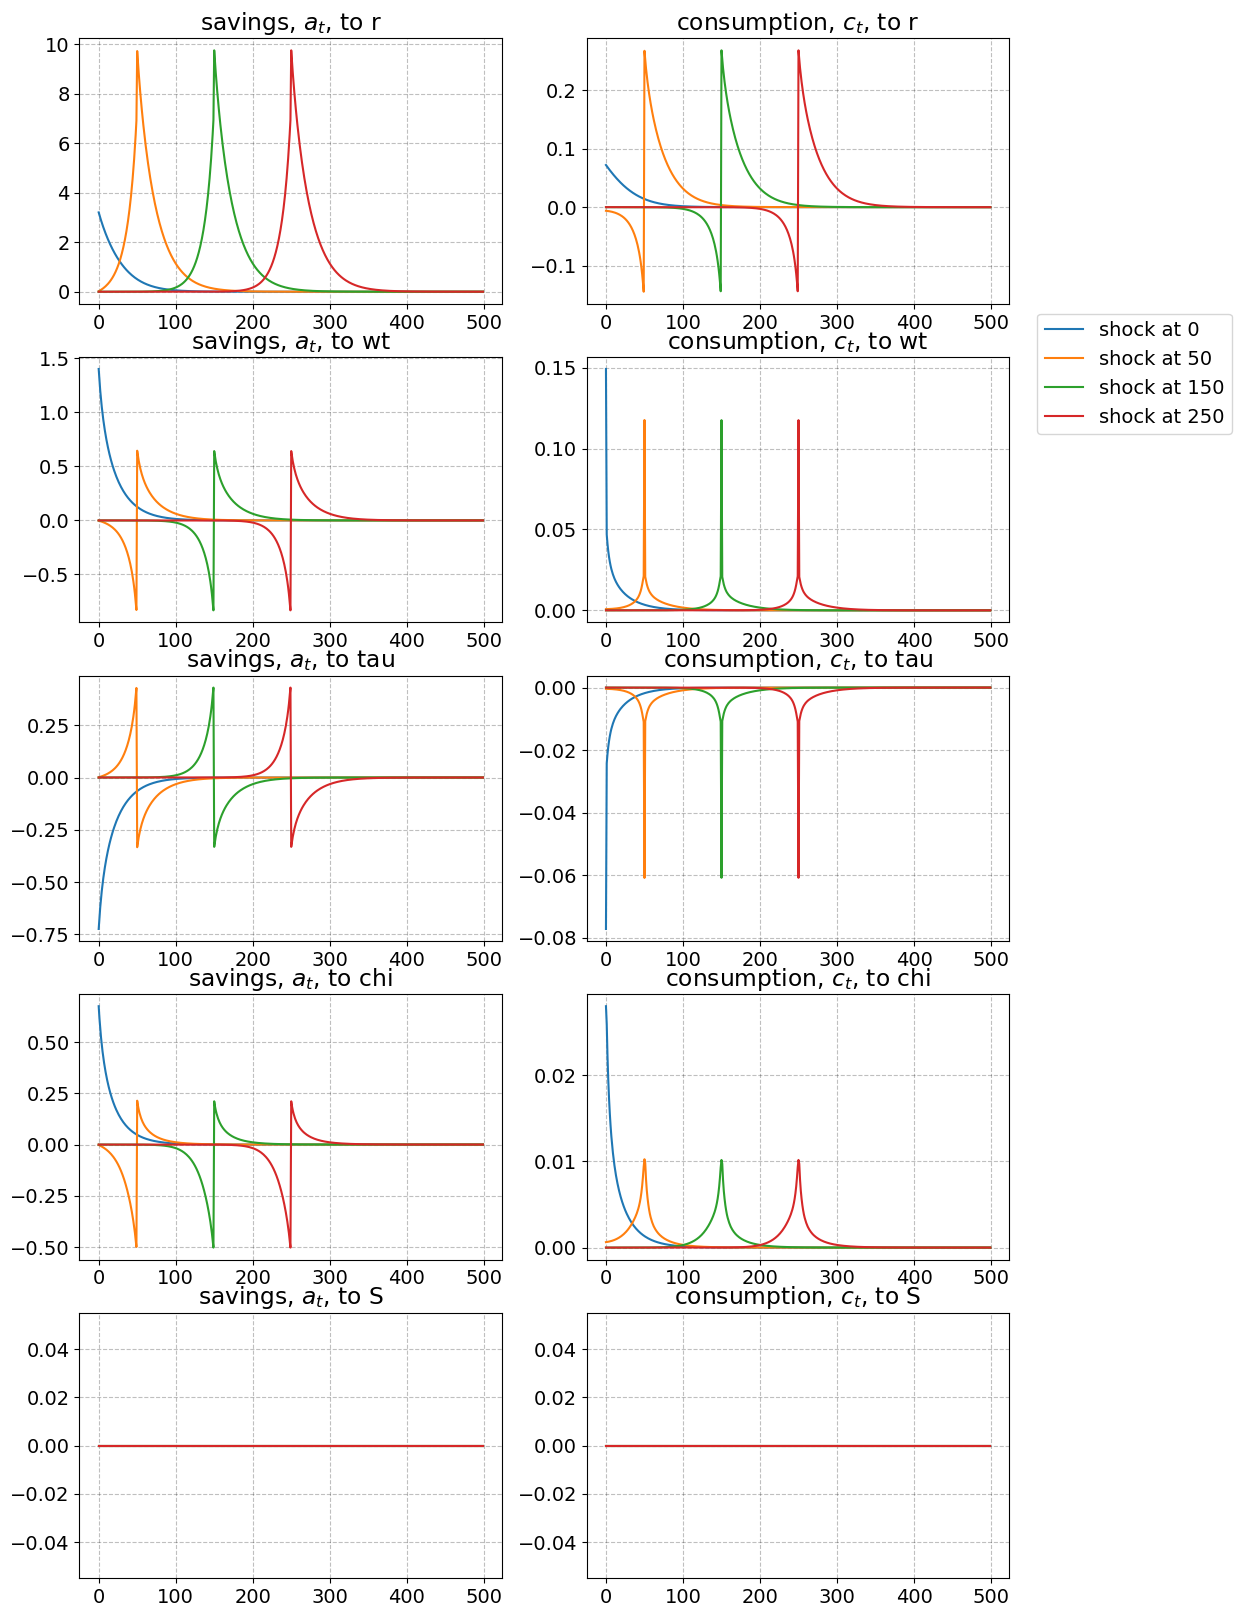

In [ ]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
        
plt.show()

['Gamma_Y']
household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 1.9 secs
household problem simulated along transition in 0.0 secs

['G']
household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.0 secs

['LG']
household problem solved along transition path in 1.1 secs
household problem simulated along transition in 0.5 secs

None
household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.0 secs

all
household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.0 secs



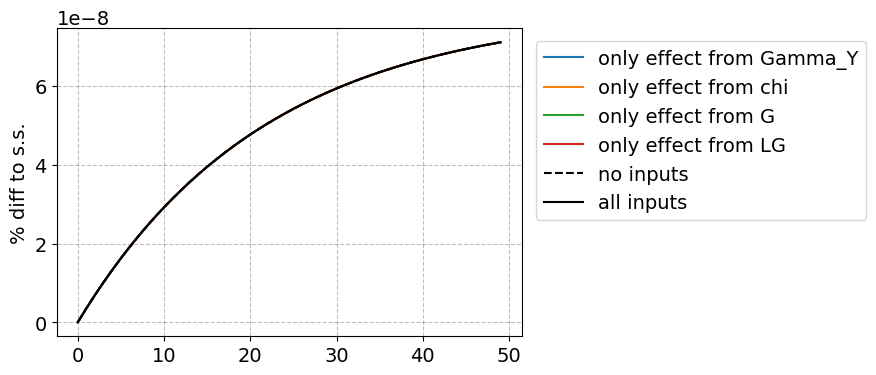

In [ ]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['Gamma_Y'],['chi'],['G'],['LG'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.2 secs
household problem simulated along transition in 0.1 secs



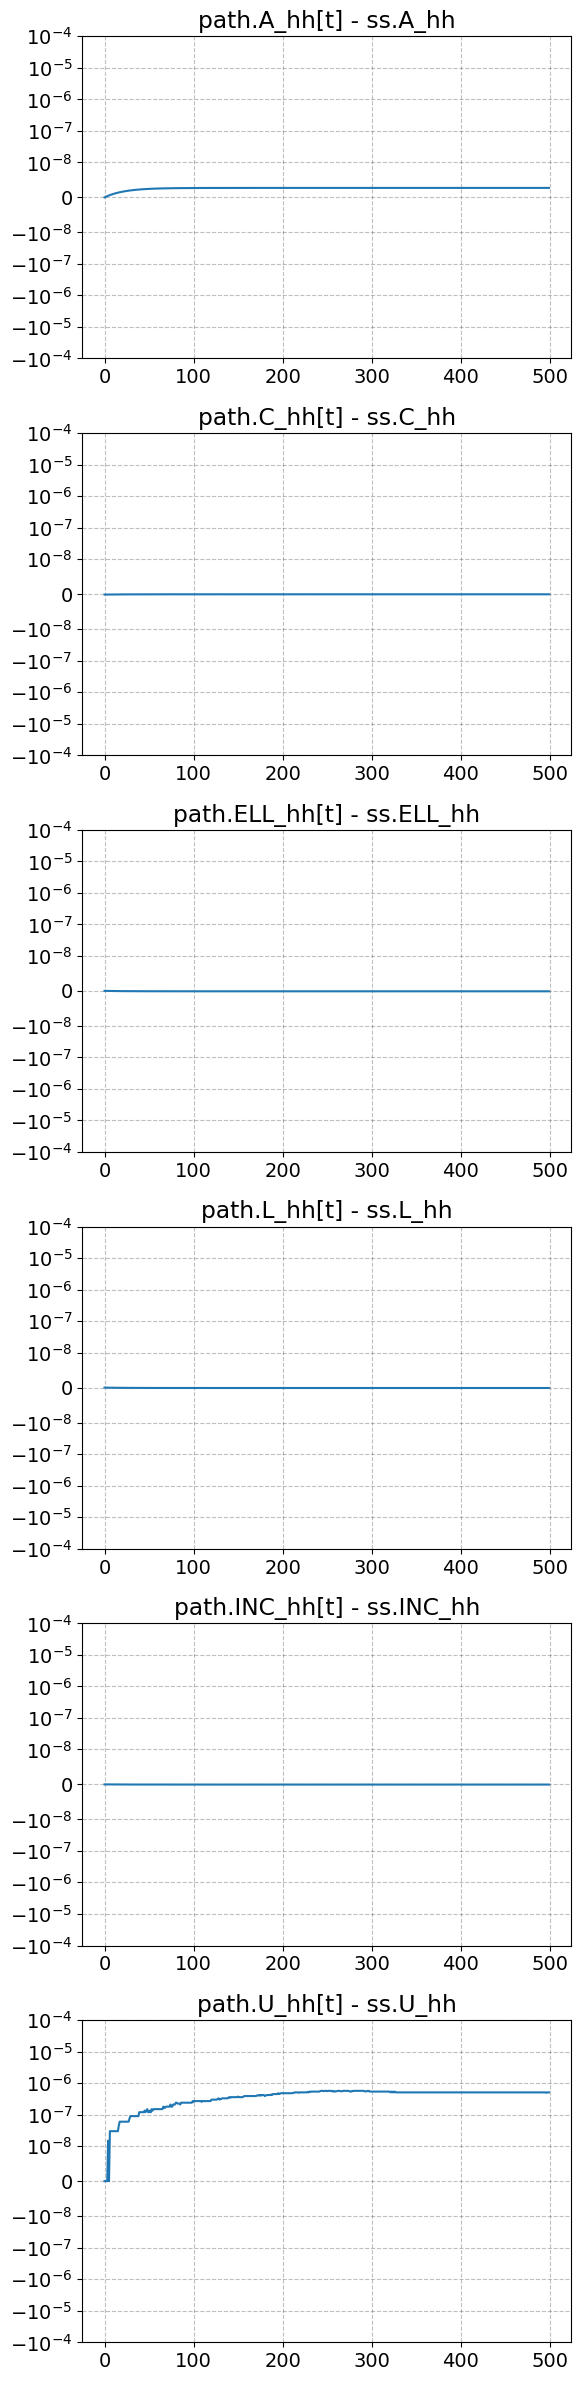

In [ ]:
model.test_hh_path()

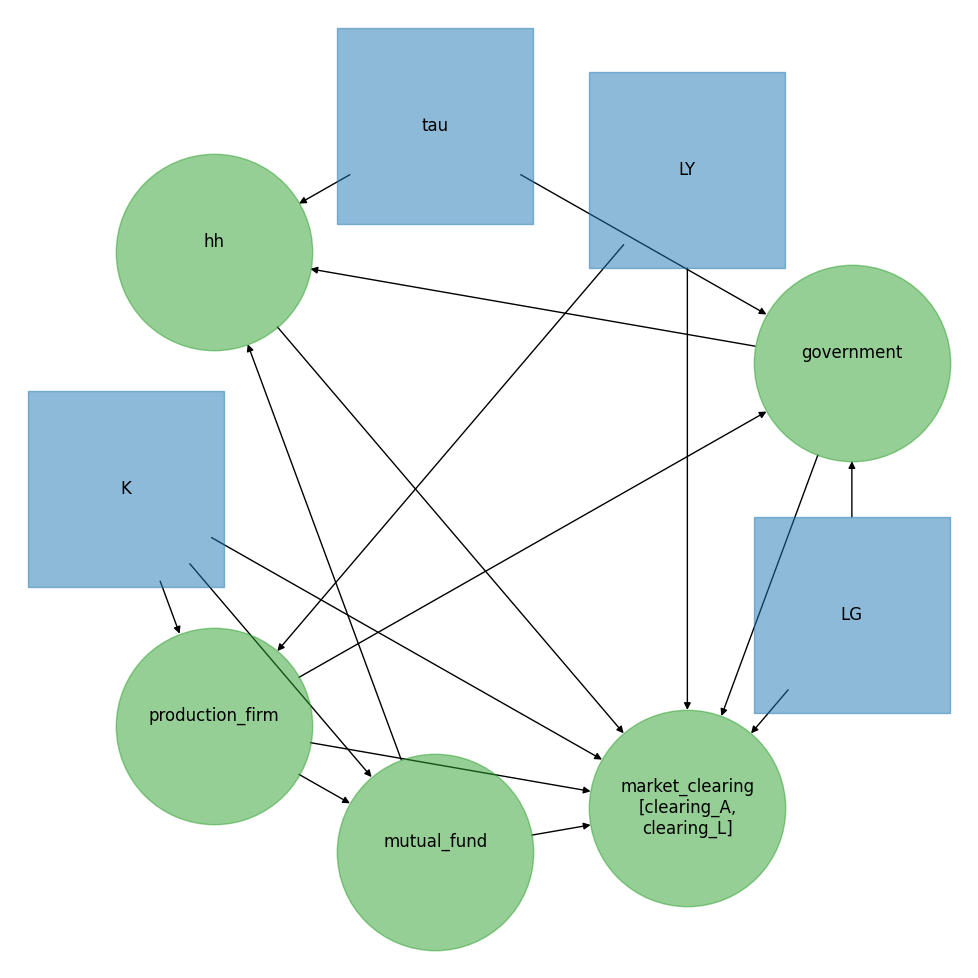

In [ ]:
model.draw_DAG(filename='DAG.png')

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

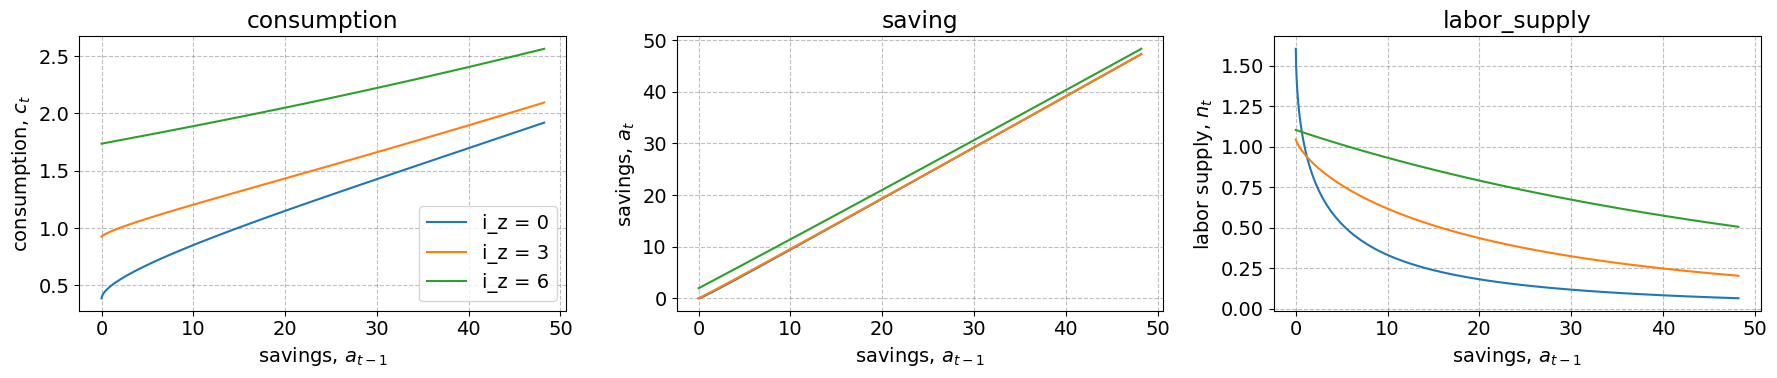

In [ ]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()